## MBAR estimation from umbrella sampling

Here, we want to be able to load various umbrella sampling trajectory data sets from file, and perform MBAR on them.

In [34]:
import numpy as np
import os, sys

def load_trajdata(trajname, indir='./trajdata'):
    """Given a trajname, load the trajectory data and umbrella information.
    
    This function will look for the following files in the indir:
    
        [trajname].npy         - the numpy array written to binary
        [trajname].description - a text file with the information about each ensemble
    
    INPUT
    trajname                      - an UmbrellaSampler object
    
    RETURNS
    trajdata               - a numpy array of shape (K, ntrials, nsamples)
    x0_values              - a list of K umbrella anchor values
    kspring_values         - a list of K spring constant values 
    """
    
    trajdata = np.load( os.path.join(indir, trajname+'.npy') )
    desc = np.loadtxt(os.path.join(indir, trajname+'.description'))
    
    x0_values = desc[:,1]
    kspring_values  = desc[:,2]

    return trajdata, x0_values, kspring_values


### Below is an example where we do *not* do statistical subsampling

In [35]:
from pymbar import MBAR # multistate Bennett acceptance ratio
from pymbar import timeseries # timeseries analysis

from UmbrellaSampler import *

nsamples_tested = [10,20,50,100,200,500,1000, 2000, 5000, 10000, 20000, 50000, 100000]
kspring = [2.0]  #[1.0, 2.0, 5.0, 10.0]

kT = 0.0019872041 * 300.0   # kcal/mol/K * K
beta = 1./kT


F_vs_nsamples_kspring  = np.zeros( (len(kspring), len(nsamples_tested)) )
dF_vs_nsamples_kspring = np.zeros( (len(kspring), len(nsamples_tested)) ) # uncertainty (std) from bootstraps 

for i_nsamples in range(len(nsamples_tested)):
    for j_kspring in range(len(kspring)):
        
        dataset = 'nsamples%s_kspring%3.1f'%(nsamples_tested[i_nsamples], kspring[j_kspring])


        print('\n#### Performing MBAR for dataset', dataset, '... ')

        trajdata, x0_values, kspring_values = load_trajdata(dataset)
        s = UmbrellaSampler(x0_values=x0_values, kspring_values=kspring_values)
        K, ntrials, nsamples = trajdata.shape
        print('#### K, ntrials, nsamples', K, ntrials, nsamples)
              
        VERBOSE = False

        # To estimate errors from finite sampling, we'll compute free energies using data from
        # trials 0 and 1, then 2 and 3, etc., because every two trial starts from the left and right basin
        nbootstraps = int(ntrials/2)
        F_estimates, dF_estimates = [], []  # estimates over bootstraps

        for boot in range(nbootstraps):

            # N_k is the number of trajectory snapshots sampled in each enesmble 
            N_k = 2*nsamples*np.ones([s.K], dtype = int)   # make an empty array for now
            if VERBOSE:
                print('N_k', N_k)
            N_max = np.max(N_k)
            if VERBOSE:
                print('N_max', N_max)
            N_tot = np.sum(N_k)

            # To instantiate the MBAR object, we create and fill the array u_kln
            K = s.K
            L = K
            
            Use_u_kln = True  # if True, use the u_kln convention with MBAR, else use u_kn
            
            if Use_u_kln:
                # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella
                # simulation k evaluated at umbrella l
                u_kln = np.zeros([K,L,N_max], np.float64)
            else:
                # u_kn[k,n] is the reduced potential energy of snapshot n from ensemble k
                # "We assume that the states are ordered such that the first N_k are from the first state,
                # the 2nd N_k the second state, and so forth. "
                u_kn = np.zeros([K,N_tot], np.float64)
                
            # To calculate (unbiased) free energies, we need to store reduced
            # energies calculated for the unbiased ensemble (k=0)
            unbiased_k = 0
            unbiased_x0 = s.x0_values[unbiased_k]
            unbiased_kspring = s.kspring_values[unbiased_k]
            print('unbiased_k', unbiased_k, 'unbiased_x0', unbiased_x0, 'unbiased_kspring', unbiased_kspring)

            u_n = np.zeros(N_tot)
            u_n_fill_indices = [0] 
            for k in range(K):
                u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])

            if VERBOSE:
                print('len(u_n_fill_indices)', len(u_n_fill_indices))
                print('u_n_fill_indices', u_n_fill_indices)
                print('len(u_n)', len(u_n))


            boot_trials = [2*boot, 2*boot+1]
            if VERBOSE:
                print('trial_indices_for_this_bootstrap', boot_trials)

            
            for k in range(s.K):    
                                
                if Use_u_kln:
                    for l in range(L):
                        u_kln[k,l,0:N_k[k]] = beta * s.dU_kl(trajdata[k,boot_trials,:], k, l).flatten()
                    u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = beta * s.dU_kl(trajdata[k,boot_trials,:], k, unbiased_k).flatten()

                else:
                    for l in range(L):
                        u_kn[l, u_n_fill_indices[k]:u_n_fill_indices[k+1]] = beta * s.dU_kl(trajdata[k,boot_trials,:], k, l).flatten()
                    u_n = u_kn[unbiased_k,:]

            if VERBOSE:
                if Use_u_kln:
                    print('u_kln', u_kln)
                else:
                    print('u_kn', u_kn)
                print('u_n', u_n)
                

            ## Instantiate the MBAR object
            #print("Running MBAR...")
            if Use_u_kln:
                mbar = MBAR(u_kln, N_k, verbose = False)
            else:
                mbar = MBAR(u_kn, N_k, verbose = False)

            if VERBOSE:
                print('Computing PMF(x) for trial', boot)

            # bin the data up into distance bins
            nbins = 2
            x_separatrix = 3.3123765271592047
            bin_centers = np.array([1.0, 5.0])
            # print('bin_centers', bin_centers)

            bin_n = np.zeros(N_tot)
            for k in range(s.K):
                bin_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
                    ((trajdata[k,boot_trials,:] > x_separatrix).astype(int)).flatten()
            print('bin_n', bin_n)

            # Compute PMF in unbiased potential (in units of kT).
            results = mbar.computePMF(u_n, bin_n, nbins)
            f_i = results[0]
            df_i = results[1]

            # Write out PMF
            if VERBOSE:
                print("PMF (in units of kT)")
                print("%8s %8s %8s %16s %16s" % ('bin', 'f', 'df', 'F (kcal/mol)', 'dF (kcal/mol)'))
                for i in range(nbins):
                    print("%8.1f %8.3f %8.3f %8.3f %8.3f" % (bin_centers[i], f_i[i], df_i[i], kT*f_i[i], kT*df_i[i]))
            F_estimates.append( kT*(f_i[0]-f_i[1]) )
            dF_estimates.append( kT*(df_i[0]-df_i[1]) )

            # cleanup
            del mbar

        print('F_estimates', F_estimates)
        print('dF_estimates', dF_estimates)

        F_vs_nsamples_kspring[j_kspring, i_nsamples] = np.mean(F_estimates)
        dF_vs_nsamples_kspring[j_kspring, i_nsamples] = np.std(F_estimates)
    
print('F_vs_nsamples_kspring', F_vs_nsamples_kspring)
print('dF_vs_nsamples_kspring', dF_vs_nsamples_kspring)



#### Performing MBAR for dataset nsamples10_kspring2.0 ... 
#### K, ntrials, nsamples 8 10 10
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

bin_n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

bin_n [0. 0. 0. ... 1. 1. 1.]
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. ... 1. 1. 1.]
F_estimates [0.7205768404102713, 0.10893723215806837, 0.23658220098756733, 0.03389739025298642, 0.4638476488526484]
dF_estimates [0.06714044747556566, 0.05961337758662023, 0.06023339445257721, 0.05955302763249488, 0.06313364952564893]

#### Performing MBAR for dataset nsamples200_kspring2.0 ... 
#### K, ntrials, nsamples 8 10 200
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. ... 1. 1. 1.]
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. ... 1. 1. 1.]
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. ... 1. 1. 1.]
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. ... 1. 1. 1.]
unbiased_k 0 unbiased_x0 0.0 unbiased_kspring 0.0
bin_n [0. 0. 0. ... 1. 1. 1.]
F_estimates [0.5470165510916035, 1.3262048698686064, 0.674184731923814, 0.533393487564256, 0.8940226134494442]
dF_estimates [0.04562829617862816, 0.0542780909

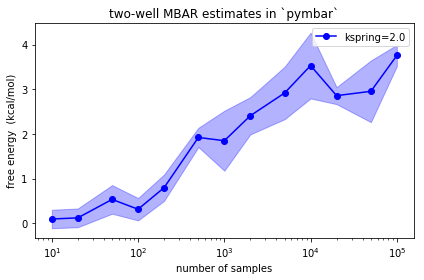

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

colors = ['b','r','g','k','m','y','c']

plt.figure( figsize=(6,4))
for j_kspring in range(len(kspring)):
    
    plt.plot(nsamples_tested, F_vs_nsamples_kspring[j_kspring,:], colors[j_kspring]+'o-', label='kspring=%3.1f'%kspring[j_kspring])
    plt.fill_between(nsamples_tested,
                     F_vs_nsamples_kspring[j_kspring,:] - dF_vs_nsamples_kspring[j_kspring,:],
                     F_vs_nsamples_kspring[j_kspring,:] + dF_vs_nsamples_kspring[j_kspring,:],
                     color=colors[j_kspring], alpha=0.3)
plt.legend(loc='best')
plt.xlabel('number of samples')
plt.ylabel('free energy  (kcal/mol)')
plt.title('two-well MBAR estimates in `pymbar`')
plt.xscale('log')
plt.tight_layout()
plt.savefig('pyMBAR_twowell.pdf')

### Next, we'll do the same calculation, but perform statistical subsampling to remove correlations in the data...

In [4]:
from pymbar import MBAR # multistate Bennett acceptance ratio
from pymbar import timeseries # timeseries analysis

from UmbrellaSampler import *

nsamples_tested = [10,20,50,100,200,500,1000] # 2000, 5000, 10000, 20000, 50000, 100000]
kspring = [2.0]  #[1.0, 2.0, 5.0, 10.0]

F_vs_nsamples_kspring  = np.zeros( (len(kspring), len(nsamples_tested)) )
dF_vs_nsamples_kspring = np.zeros( (len(kspring), len(nsamples_tested)) ) # uncertainty (std) from bootstraps 

for i_nsamples in range(len(nsamples_tested)):
    for j_kspring in range(len(kspring)):
        
        dataset = 'nsamples%s_kspring%3.1f'%(nsamples_tested[i_nsamples], kspring[j_kspring])


        print('\n#### Performing MBAR for dataset', dataset, '... ')

        trajdata, x0_values, kspring_values = load_trajdata(dataset)
        s = UmbrellaSampler(x0_values=x0_values, kspring_values=kspring_values)
        K, ntrials, nsamples = trajdata.shape
        print('#### K, ntrials, nsamples', K, ntrials, nsamples)
        
        for trial in range(ntrials):
            
            ### Discard unequilibrated data and subsample correlated data
            [t0, g, Neff_max] = timeseries.detectEquilibration(trajdata[0,trial,:]) # compute indices of uncorrelated timeseries
            print('trial', trial, 't0', t0, 'g', g, 'Neff_max', Neff_max)
            # A_t_equil = A_t[t0:]
            # indices = timeseries.subsampleCorrelatedData(A_t_equil, g=g)
            # A_n = A_t_equil[indices]
        

        VERBOSE = False

        # To estimate errors from finite sampling, we'll compute free energies using data from
        # trials 0 and 1, then 2 and 3, etc., because every two trial starts from the left and right basin
        nbootstraps = int(ntrials/2)
        F_estimates, dF_estimates = [], []  # estimates over bootstraps

        for boot in range(nbootstraps):

            # N_k is the number of trajectory snapshots sampled in each enesmble 
            N_k = 2*nsamples*np.ones([s.K], dtype = int)   # make an empty array for now
            if VERBOSE:
                print('N_k', N_k)
            N_max = np.max(N_k)
            if VERBOSE:
                print('N_max', N_max)

            # To instantiate the MBAR object, we create and fill the array u_kln
            K = s.K
            L = K
            u_kln = np.zeros([K,L,N_max], np.float64) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella 

            # To calculate (unbiased) free energies, we need to store reduced
            # energies calculated for the unbiased ensemble (k=0)
            unbiased_k = 0

            N_tot = N_k.sum()
            u_n = np.zeros(N_tot)
            u_n_fill_indices = [0] 
            for k in range(K):
                u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])

            if VERBOSE:
                print('len(u_n_fill_indices)', len(u_n_fill_indices))
                print('u_n_fill_indices', u_n_fill_indices)
                print('len(u_n)', len(u_n))


            boot_trials = [2*boot, 2*boot+1]
            if VERBOSE:
                print('trial_indices_for_this_bootstrap', boot_trials)

            for k in range(s.K):    
                u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
                    (s.U(trajdata[k,boot_trials,:], s.x0_values[unbiased_k], s.kspring_values[unbiased_k])).flatten()
                for l in range(L):
                    u_kln[k,l,0:N_k[k]] = s.dU_kl(trajdata[k,boot_trials,:], k, l).flatten()
            if VERBOSE:
                print('u_kln', u_kln)
                print('u_n', u_n)


            ## Instantiate the MBAR object
            #print("Running MBAR...")
            mbar = MBAR(u_kln, N_k, verbose = False)

            if VERBOSE:
                print('Computing PMF(x) for trial', trial)

            # bin the data up into distance bins
            nbins = 2
            x_separatrix = 3.3123765271592047
            dmin, dmax = x_separatrix, (x_separatrix + 10.0)  # in nm
            dwidth = (dmax-dmin)/nbins
            distance_bins = np.arange(dmin, dmax+dwidth, dwidth)
            bin_centers = (distance_bins[0:-1]+distance_bins[1:])/2.0
            # print('bin_centers', bin_centers)

            bin_n = np.zeros(N_tot)

            for k in range(s.K):
                bin_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
                    np.digitize(trajdata[k,boot_trials,:], distance_bins, right=False).flatten()
            # print('bin_n', bin_n)

            # Compute PMF in unbiased potential (in units of kT).
            results = mbar.computePMF(u_n, bin_n, nbins)
            f_i = results[0]
            df_i = results[1]

            # Write out PMF
            kT = 0.0019872041 * 300.0   # kcal/mol/K * K
            beta = 1./kT
            if VERBOSE:
                print("PMF (in units of kT)")
                print("%8s %8s %8s %16s %16s" % ('bin', 'f', 'df', 'F (kcal/mol)', 'dF (kcal/mol)'))
                for i in range(nbins):
                    print("%8.1f %8.3f %8.3f %8.3f %8.3f" % (bin_centers[i], f_i[i], df_i[i], kT*f_i[i], kT*df_i[i]))
            F_estimates.append( kT*(f_i[0]-f_i[1]) )
            dF_estimates.append( kT*(df_i[0]-df_i[1]) )

            # cleanup
            del mbar

        print('F_estimates', F_estimates)
        print('dF_estimates', dF_estimates)

        F_vs_nsamples_kspring[j_kspring, i_nsamples] = np.mean(F_estimates)
        dF_vs_nsamples_kspring[j_kspring, i_nsamples] = np.std(F_estimates)
    
print('F_vs_nsamples_kspring', F_vs_nsamples_kspring)
print('dF_vs_nsamples_kspring', dF_vs_nsamples_kspring)




#### Performing MBAR for dataset nsamples10_kspring2.0 ... 
#### K, ntrials, nsamples 8 10 10
trial 0 t0 0 g 1.0 Neff_max 11.0
trial 1 t0 2 g 1.0 Neff_max 9.0
trial 2 t0 0 g 1.2465565 Neff_max 8.824309
trial 3 t0 3 g 1.0 Neff_max 8.0
trial 4 t0 2 g 1.0 Neff_max 9.0
trial 5 t0 3 g 1.0 Neff_max 8.0
trial 6 t0 4 g 1.0 Neff_max 7.0
trial 7 t0 0 g 1.0 Neff_max 11.0
trial 8 t0 0 g 1.0 Neff_max 11.0
trial 9 t0 0 g 1.0 Neff_max 11.0
F_estimates [2.402083715750992, 2.3671089411362822, 2.398195093861159, 2.778297700186923, 2.3418739439401484]
dF_estimates [0.2010325519912255, 0.1990252756497176, 0.19861165797366087, 0.19905310575281146, 0.19984491300673973]

#### Performing MBAR for dataset nsamples20_kspring2.0 ... 
#### K, ntrials, nsamples 8 10 20
trial 0 t0 0 g 1.3930544 Neff_max 15.074788
trial 1 t0 0 g 1.0 Neff_max 21.0
trial 2 t0 0 g 1.0 Neff_max 21.0
trial 3 t0 0 g 1.0 Neff_max 21.0
trial 4 t0 8 g 1.0 Neff_max 13.0
trial 5 t0 0 g 1.0 Neff_max 21.0
trial 6 t0 0 g 1.0 Neff_max 21.0
trial 